In [83]:
from empca_residuals import *
import gaia_tools.load as gload
from gaia_tools import xmatch
import matplotlib.pyplot as plt
import matplotlib
import warnings
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [84]:
font = {'family': 'serif',
        'weight': 'normal',
        'size'  :  18
}

matplotlib.rc('font',**font)


In [2]:
tgas_cat= gload.tgas()

In [154]:
tgas_cat.dtype

dtype([('hip', '>i4'), ('tycho2_id', 'S12'), ('solution_id', '>i8'), ('source_id', '>i8'), ('random_index', '>i8'), ('ref_epoch', '>f8'), ('ra', '>f8'), ('ra_error', '>f8'), ('dec', '>f8'), ('dec_error', '>f8'), ('parallax', '>f8'), ('parallax_error', '>f8'), ('pmra', '>f8'), ('pmra_error', '>f8'), ('pmdec', '>f8'), ('pmdec_error', '>f8'), ('ra_dec_corr', '>f4'), ('ra_parallax_corr', '>f4'), ('ra_pmra_corr', '>f4'), ('ra_pmdec_corr', '>f4'), ('dec_parallax_corr', '>f4'), ('dec_pmra_corr', '>f4'), ('dec_pmdec_corr', '>f4'), ('parallax_pmra_corr', '>f4'), ('parallax_pmdec_corr', '>f4'), ('pmra_pmdec_corr', '>f4'), ('astrometric_n_obs_al', '>i4'), ('astrometric_n_obs_ac', '>i4'), ('astrometric_n_good_obs_al', '>i4'), ('astrometric_n_good_obs_ac', '>i4'), ('astrometric_n_bad_obs_al', '>i4'), ('astrometric_n_bad_obs_ac', '>i4'), ('astrometric_delta_q', '>f4'), ('astrometric_excess_noise', '>f8'), ('astrometric_excess_noise_sig', '>f8'), ('astrometric_primary_flag', '?'), ('astrometric_releg

In [153]:
np.min(tgas_cat['parallax']),np.max(tgas_cat['parallax'])

(-24.819952295536908, 295.80363766060833)

In [ ]:
 # Start figure                                                                                                                            
plt.figure(figsize=(10,5.5))
# Set up Cartesian axes                                                                                                                   
car = plt.subplot(121)
# Set up polar axes                                                                                                                       
pol = plt.subplot(122,projection='polar')

# Find location data                                                                                                                      
phi = self.data['RC_GALPHI']
r = self.data['RC_GALR']
z = self.data['RC_GALZ']

# Plot data                                                                                                                               
car.plot(r,z,'ko',markersize=2,alpha=0.2)
pol.plot(phi,r,'ko',markersize=2,alpha=0.2)
# Reorient polar plot to match convention                                                                                                 
pol.set_theta_direction(-1)

# Constrain plot limits and set labels                                                                                                    
car.set_xlim(min(r),max(r))
car.set_ylim(min(z),max(z))
car.set_xlabel('R (kpc)')
car.set_ylabel('z (kpc)')
pol.set_rlabel_position(135)
pol.set_rlim(min(r),max(r))
pol.set_xticks([])
plt.subplots_adjust(wspace=0.05)

In [64]:
def all_match(central,catalog,epoch1=2000.,epoch2=2015.,maxdist=2):
    depoch= epoch2-epoch1
    if depoch != 0.:
        # Use proper motion to get both catalogs at the same time
        dra=catalog['pmra']/numpy.cos(catalog['dec']/180.*numpy.pi)\
            /3600000.*depoch
        ddec= catalog['pmdec']/3600000.*depoch
    cat_ras = catalog['ra']-dra
    ra_errs = catalog['ra_error']
    cat_decs = catalog['dec']-ddec
    dec_errs = catalog['dec_error']
    rabound_min = central['ra']-(maxdist/3600.)
    rabound_max = central['ra']+(maxdist/3600.)
    decbound_min = central['dec']-(maxdist/3600.)
    decbound_max = central['dec']+(maxdist/3600.)
    # Find right ascension match
    if rabound_min > 0. and rabound_max < 360.:
        ramatch = (cat_ras>rabound_min) & (cat_ras<rabound_max)
        raplusmatch = (cat_ras+ra_errs>rabound_min) & (cat_ras+ra_errs<rabound_max)
        raminusmatch = (cat_ras-ra_errs>rabound_min) & (cat_ras-ra_errs<rabound_max)
    elif rabound_min < 0. and rabound_max < 360.: 
        ramatch = ((cat_ras>0.) & (cat_ras<rabound_max)) | ((cat_ras>rabound_min+360.) & (cat_ras<360.))
        raplusmatch = ((cat_ras+ra_errs>0.) & (cat_ras+ra_errs<rabound_max)) | ((cat_ras+ra_errs>rabound_min+360.) & (cat_ras+ra_errs<360.))
        raminusmatch = ((cat_ras-ra_errs>0.) & (cat_ras-ra_errs<rabound_max)) | ((cat_ras-ra_errs>rabound_min+360.) & (cat_ras-ra_errs<360.))
    elif rabound_min > 0. and rabound_max > 360.:
        ramatch = ((cat_ras>rabound_min) & (cat_ras<360.)) | ((cat_ras>0.) & (cat_ras<rabound_max-360.))
        raplusmatch = ((cat_ras+ra_errs>rabound_min) & (cat_ras+ra_errs<360.)) | ((cat_ras+ra_errs>0.) & (cat_ras+ra_errs<rabound_max-360.))
        raminusmatch = ((cat_ras-ra_errs>rabound_min) & (cat_ras-ra_errs<360.)) | ((cat_ras-ra_errs>0.) & (cat_ras-ra_errs<rabound_max-360.))
    elif rabound_min < 0. and rabound_max > 360.:
        warnings.warn('Your range spans the whole sky in right ascension, exiting')
        ramatch = False
        raplusmatch = False
        raminusmatch = False
        
    if decbound_min > 0. and decbound_max < 360.:
        decmatch = (cat_decs>decbound_min) & (cat_decs<decbound_max)
        decplusmatch = (cat_decs+dec_errs>decbound_min) & (cat_decs+dec_errs<decbound_max)
        decminusmatch = (cat_decs-dec_errs>decbound_min) & (cat_decs-dec_errs<decbound_max)
    elif decbound_min < 0. and rdecbound_max < 360.: 
        decmatch = ((cat_decs>0.) & (cat_decs<decbound_max)) | ((cat_decs>decbound_min+360.) & (cat_decs<360.))
        decplusmatch = ((cat_decs+dec_errs>0.) & (cat_decs+dec_errs<decbound_max)) | ((cat_decs+dec_errs>decbound_min+360.) & (cat_decs+dec_errs<360.))
        decminusmatch = ((cat_decs-dec_errs>0.) & (cat_decs-dec_errs<decbound_max)) | ((cat_decs-dec_errs>decbound_min+360.) & (cat_decs-dec_errs<360.))
    elif decbound_min > 0. and decbound_max > 360.:
        decmatch = ((cat_decs>decbound_min) & (cat_decs<360.)) | ((cat_decs>0.) & (cat_decs<decbound_max-360.))
        decplusmatch = ((cat_decs+dec_errs>decbound_min) & (cat_decs+dec_errs<360.)) | ((cat_decs+dec_errs>0.) & (cat_decs+dec_errs<decbound_max-360.))
        decminusmatch = ((cat_decs-dec_errs>decbound_min) & (cat_decs-dec_errs<360.)) | ((cat_decs-dec_errs>0.) & (cat_decs-dec_errs<decbound_max-360.))
    elif decbound_min < 0. and decbound_max > 360.:
        warnings.warn('Your range spans the whole sky in declination, exiting')
        decmatch = False
        decplusmatch = False
        decminusmatch = False
    return (ramatch & decmatch) | (raplusmatch & decmatch) | (raminusmatch & decmatch) | (ramatch & decplusmatch) | (raplusmatch & decplusmatch) | (raminusmatch & decplusmatch) | (ramatch & decminusmatch) | (raplusmatch & decminusmatch) | (raminusmatch & decminusmatch)
        

In [141]:
def plot_tgas_match(loc,dist,ang_rad):
    match = all_match(loc,tgas_cat,epoch1=2000,epoch2=2015.,maxdist=ang_rad)
    if np.sum(match)!= 0:
        plt.figure(figsize=(18,8))
        plt.subplot2grid((1,2),(0,0))
        plt.errorbar(tgas_cat[match]['ra'],tgas_cat[match]['dec'],
                     xerr=tgas_cat[match]['ra_error'],yerr=tgas_cat[match]['dec_error'],
                     fmt='o',ecolor='red',label='{0} stars'.format(np.sum(match)))
        plt.plot(loc['ra'],loc['dec'],'o',color='c',markersize=10,label='cluster center')
        plt.legend(loc='best')
        plt.axvline(loc['ra']-ang_rad/3600.,ls='--')
        plt.axvline(loc['ra']+ang_rad/3600.,ls='--')
        plt.axhline(loc['dec']-ang_rad/3600.,ls='--')
        plt.axhline(loc['dec']+ang_rad/3600.,ls='--')
        plt.xlabel('right ascension')
        plt.ylabel('declination')
        plt.axis('equal')
        plt.subplot2grid((1,2),(0,1))
        plt.errorbar(tgas_cat[match]['pmra'],tgas_cat[match]['pmdec'],
                     xerr=tgas_cat[match]['pmra_error'],yerr=tgas_cat[match]['pmdec_error'],
                     fmt='o',ecolor='r')
        plt.xlabel('right ascension proper motion')
        plt.ylabel('declination proper motion')
        plt.axis('equal')
    elif np.sum(match) == 0:
        print 'No TGAS match'
    return match

In [142]:
# cluster radius in pc
rad = 2.

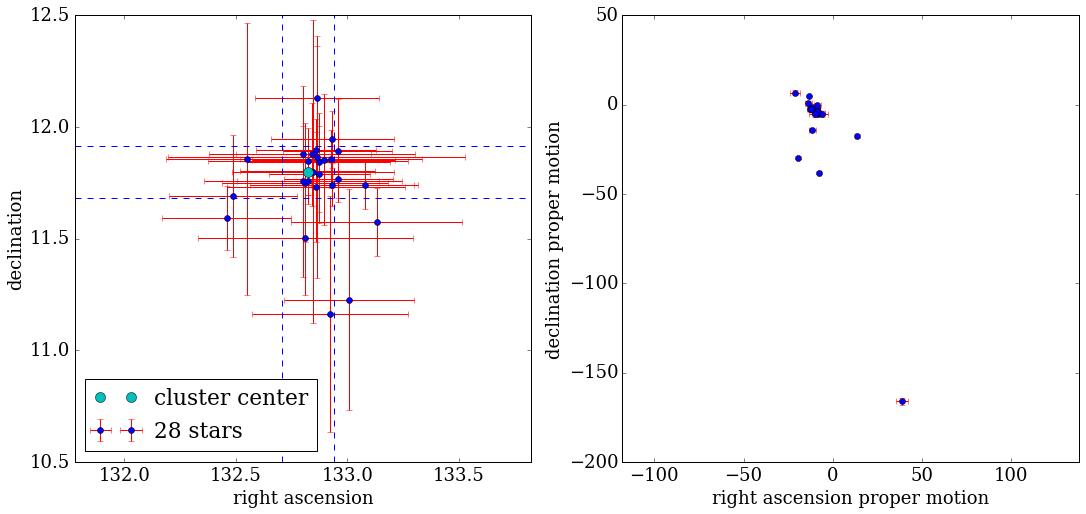

In [147]:
#M67
c = SkyCoord('08h51m18.0s','+11d48m00s',frame='icrs') # from Xin & Deng 2005
m67_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
m67_dist = 986.279 # in pc from Pandey, Sandhu, Sagar & Battinelli 2010
m67_ang_rad = np.arctan(rad/m67_dist)*(180./np.pi)*3600. #angular radius in arcseconds
m67_match = plot_tgas_match(m67_loc,m67_dist,m67_ang_rad)

In [149]:
#M107
c = SkyCoord('16h41m41.634s','+36d27m40.75s',frame='icrs') # from Goldsbury et al 2010
m107_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
m107_dist = 6.4*1e3 # in pc from A. Possenti 2010, unpublished
m107_ang_rad = np.arctan(rad/m107_dist)*(180./np.pi)*3600. #angular radius in arcseconds
m107_match = plot_tgas_match(m107_loc,m107_dist,m107_ang_rad)

No TGAS match


In [146]:
#M13
c = SkyCoord('16h32m31.86s','+-13d03m13.6s',frame='icrs') # from Skrutskie et al 2006
m13_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
m13_dist = 6.8*1e3 # in pc from Paust et al 2010
m13_ang_rad = np.arctan(rad/m13_dist)*(180./np.pi)*3600. #angular radius in arcseconds
m13_match = plot_tgas_match(m13_loc,m13_dist,m13_ang_rad)

No TGAS match
